In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:

import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

In [83]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from utils.filepaths.filepaths import FILE_PATH_TRANSIENT_TRAINING_DATA_102_TARGETS, FILE_PATH_TRANSIENT_TRAINING_DATA_102_FEATURES, FILE_PATH_TRANSIENT_TRAINING_DATA_101_FEATURES,FILE_PATH_TRANSIENT_TRAINING_DATA_101_TARGETS,FILE_PATH_TRANSIENT_TRAINING_DATA_102b_FEATURES, FILE_PATH_TRANSIENT_TRAINING_DATA_102b_TARGETS, FILE_PATH_TRANSIENT_OTHER_VARIABLES_102b,FILE_PATH_TRANSIENT_OTHER_VARIABLES_102,FILE_PATH_TRANSIENT_OTHER_VARIABLES_101
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from scipy.stats import skew, kurtosis
from tqdm import tqdm

from utils.training.training import inner_fold_for_hyperparameter_optimization
sns.set_theme()

In [84]:
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102_FEATURES, 'rb') as file:
    features_102 = pickle.load(file)
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102_TARGETS, 'rb') as file:
    targets_102 = pickle.load(file)
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_101_FEATURES, 'rb') as file:
    features_101 = pickle.load(file)
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_101_TARGETS, 'rb') as file:
    targets_101 = pickle.load(file)
# with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102b_FEATURES, 'rb') as file:
#     features_102b = pickle.load(file)
# with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102b_TARGETS, 'rb') as file:
#     targets_102b = pickle.load(file)
with open (FILE_PATH_TRANSIENT_OTHER_VARIABLES_101, 'rb') as file:
    other_variables_101= pickle.load(file)
with open (FILE_PATH_TRANSIENT_OTHER_VARIABLES_102, 'rb') as file:
    other_variables_102 = pickle.load(file)
# with open (FILE_PATH_TRANSIENT_OTHER_VARIABLES_102b, 'rb') as file:
#     other_variables_102b = pickle.load(file)

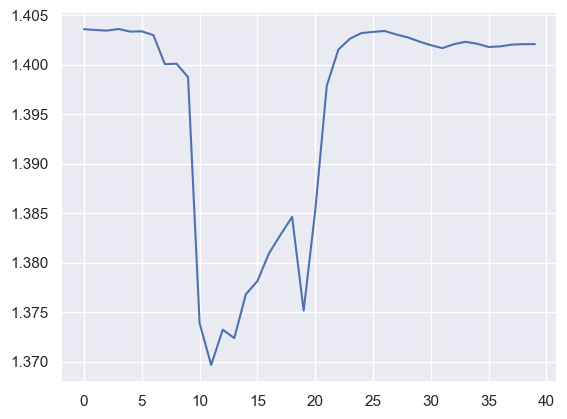

In [85]:
plt.plot(targets_102[9])

In [86]:
# for idx in range(len(targets_101)):
#     plt.plot(targets_101[idx])
#     plt.show()

In [87]:
rng = np.random.default_rng()
features = np.concatenate((features_102, features_101), axis = 0)
targets = np.concatenate((targets_102, targets_101), axis = 0)
other_variables = np.concatenate((other_variables_102, other_variables_101), axis = 0)
# targets = targets - other_variables[:,:,0]
indices =  ["$Re$", "$Ta$", "$Bh$", "$f$", "$Ro$", "$Sh$"]
permutation = rng.permutation(len(features))
permutation_1 = [12,  3,  5, 10, 13,  2,  7,  9, 14, 11,  0,  4,  8,  1,  6]
permutation_2 = [10,13, 12, 14,  8,  9,  5,  4,  3,  2,  1,  6,  7, 11,  0]
permutation_3 = [ 6,  9,  7, 14, 11, 13,  3,  1,  5,  0, 10,  4,  8, 12,  2]
permutation = permutation_2
features = features[permutation]
targets = targets[permutation]
other_variables = other_variables[permutation]

In [88]:
print(features.shape, targets.shape)

(15, 40, 6) (15, 40)


In [89]:
features_sans_bingham = np.delete(features,2,axis = 2)
indices_sans_bingham = np.delete(indices, 2)

features_sans_shields_and_bingham =np.delete(np.delete(features, 2, axis = 2),4,axis = 2) 
indices_sans_shields_and_bingham = np.delete(np.delete(indices, 2), 4)

features_sans_friction_and_bingham = np.delete(np.delete(features, 2, axis = 2),2,axis = 2)
indices_sans_friction_and_bingham = np.delete(np.delete(indices, 2), 2)

features_sans_rouse_shields_and_bingham = np.delete(np.delete(np.delete(features, 2, axis = 2),4,axis = 2),3, axis = 2) 
indices_sans_rouse_shields_and_bingham =np.delete(np.delete(np.delete(indices, 2), 4),3)

# print(features_sans_rouse_shields_and_bingham.shape)
# features = features_sans_bingham
# indices = indices_sans_bingham

In [90]:
# Splitting datasets
training_features = features[:int(0.9 * len(features))]
testing_features = features[int(0.9 * len(features)):]
other_variables_training = other_variables[:int(0.9 * len(features))]
other_variables_validation = other_variables[int(0.9 * len(features)):]

training_targets = targets[:int(0.9 * len(targets))]
testing_targets = targets[int(0.9 * len(targets)):]

In [91]:
# Normalizing not necassary for rf i think
# training_features = (training_features - training_features.mean(axis = (0,1))) / training_features.std(axis = (0,1)) 
# validation_features = (validation_features - training_features.mean(axis = (0,1))) / training_features.std(axis = (0,1)) 

In [92]:
training_features = training_features.reshape(training_features.shape[0],features.shape[1]*features.shape[2])
testing_features = testing_features.reshape(testing_features.shape[0],features.shape[1]*features.shape[2])
print(training_features.shape, testing_features.shape)

(13, 240) (2, 240)


In [93]:
param_grid_rf = {
    'n_estimators': [1000],
    'max_depth': [9,10,11],
    'min_samples_split': [1,2,3],                   # Minimum samples required to split a node
    'min_samples_leaf': [1,2,3],                     # Minimum samples required at a leaf node
    'bootstrap': [True],
    'criterion' : ['squared_error'],
    'max_features' : ['log2','sqrt']
}

In [94]:
kfold_inner = KFold(n_splits = 4)
kfold = KFold(n_splits=len(training_features))
data_k_fold = {}
best_val = 100000
best_params = {}
best_fold = 0
for fold, (train_index, val_index) in tqdm(enumerate(kfold.split(training_features))):
    X_train, X_val = training_features[train_index],training_features[val_index] 
    y_train, y_val = training_targets[train_index], training_targets[val_index]
    other_train, other_val = other_variables_training[train_index], other_variables_training[val_index]
    # fitted_grid_search_cv = inner_fold_for_hyperparameter_optimization(k_fold_inner=kfold_inner, model = RandomForestRegressor, X=X_train, y = y_train,param_grid=param_grid_rf, task = "regression", n_iter = 27)
    # model = RandomForestRegressor(**fitted_grid_search_cv.best_params_)
    model = RandomForestRegressor(random_state=42, n_estimators=1000, max_depth = 10)
    model_fited = model.fit(X_train,y_train)
    model_train_predict = model.predict(X_train)
    yhat_val = model_fited.predict(X_val)
    validation_mse = np.mean(np.power(yhat_val - y_val,2))
    data_k_fold[f'Fold {fold + 1}'] = {}
    if validation_mse < best_val:
        best_val = validation_mse
        # best_params = fitted_grid_search_cv.best_params_
        best_fold = fold + 1
    
    data_k_fold[f'Fold {fold + 1}']["Training features"] =X_train.reshape(X_train.shape[0], features.shape[1], features.shape[2])
    data_k_fold[f'Fold {fold + 1}']["Training targets"] =y_train
    data_k_fold[f'Fold {fold + 1}']["Validation features"] =X_val.reshape(X_val.shape[0], features.shape[1], features.shape[2])
    data_k_fold[f'Fold {fold + 1}']["Validation targets"] =y_val
    data_k_fold[f'Fold {fold + 1}']["Other variables training"] =other_train
    data_k_fold[f'Fold {fold + 1}']["Other variables validation"] =other_val
    data_k_fold[f'Fold {fold + 1}']["Predictions"] = yhat_val
    data_k_fold[f'Fold {fold + 1}']["Validation MSE"] = validation_mse
    data_k_fold[f'Fold {fold + 1}']["Train MSE"] = np.mean(np.power(model_train_predict - y_train,2))



13it [00:19,  1.53s/it]


MSE for fold Fold 1 0.0004790221994108291
MSE for fold Fold 1 8.961748602414825e-05 model
MSE for fold Fold 2 0.00044485448841299555
MSE for fold Fold 2 1.5637700742169795e-05 model
MSE for fold Fold 3 0.00029101748116123664
MSE for fold Fold 3 0.0003966643683511635 model
MSE for fold Fold 4 0.0003631675232682456
MSE for fold Fold 4 7.173999114724966e-06 model
MSE for fold Fold 5 3.930539853998792e-05
MSE for fold Fold 5 0.0003426839181000134 model
MSE for fold Fold 6 0.0004538615070449198
MSE for fold Fold 6 0.00020682862348640708 model
MSE for fold Fold 7 0.00024191471414245703
MSE for fold Fold 7 6.958582703928411e-05 model
MSE for fold Fold 8 1.8414313456410524e-05
MSE for fold Fold 8 6.341603431756434e-05 model
MSE for fold Fold 9 1.44771542835081e-05
MSE for fold Fold 9 6.684943080605948e-05 model
MSE for fold Fold 10 2.2245857476812734e-05
MSE for fold Fold 10 3.0294872137836323e-05 model
MSE for fold Fold 11 2.2323458436859498e-05
MSE for fold Fold 11 5.851917907904131e-05 mode

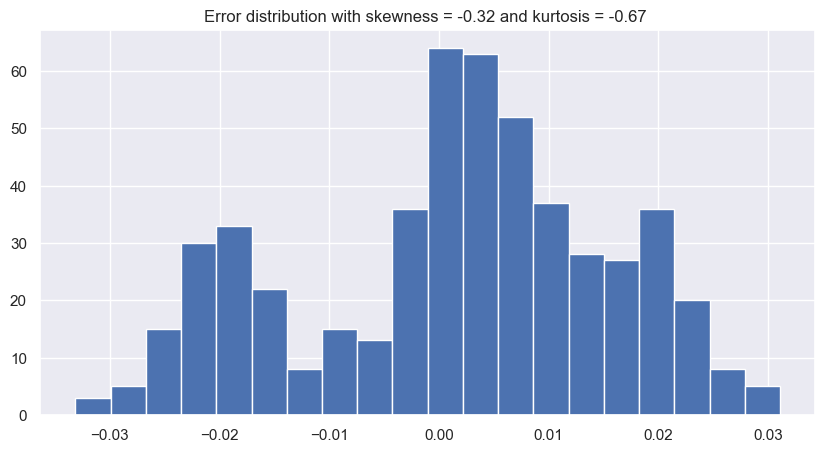

In [95]:
mse = []
mses_train = []
mses_model = []
errors = np.array([])
n_bins = 10

for fold in data_k_fold:

    mse_fold =data_k_fold[fold]["Validation MSE"]
    mse_model = np.mean(np.power(data_k_fold[fold]["Validation targets"] - data_k_fold[fold]["Other variables validation"][:,:,1],2))
    mses_model.append(mse_model)
    mse.append(mse_fold)
    mses_train.append(data_k_fold[fold]["Train MSE"])
    print(f'MSE for fold {fold} {mse_fold}') 
    print(f'MSE for fold {fold} {mse_model} model') 
    # plt.figure(figsize = (10,10))
    # plt.title("Targets and predictions of ASM1 ECD")
    # plt.plot(data_k_fold[fold]["Validation targets"][0],label = "ASM 1")
    # plt.plot(data_k_fold[fold]["Predictions"][0], label = f"Predictions ASM 1 {mse_fold:.2f}")
    # plt.legend()
    # plt.ylabel(r'$\text{ECD} [\text{gcm}^{-3}]$')
    # plt.xlabel('Time [10s]')
    # plt.show()
    error = -data_k_fold[fold]["Validation targets"][0] + data_k_fold[fold]["Predictions"][0]
    errors = np.concatenate([errors,error],axis =0)
    # plt.hist(-data_k_fold[fold]["Validation targets"][0] + data_k_fold[fold]["Predictions"][0],bins = n_bins)
    # plt.show()
mean_mse = np.mean(mse)
std_mse = np.std(mse)
mean_train_mse = np.mean(mses_train)
print(f'Mean MSE: {mean_mse} and std mse: {std_mse}')
print(f'Mean MSE model: {np.mean(mses_model)} and std mse: {np.std(mses_model)}')
print(f'Mean train MSE : {mean_train_mse}')
plt.figure(figsize=(10,5))
plt.title(f"Error distribution with skewness = {skew(errors):.2f} and kurtosis = {kurtosis(errors):.2f} ")
plt.hist(errors, bins = 20)
plt.show()

In [96]:
# what is up with fold 9?
# Bad performance due to data from different field operation
# fold_9_features = data_k_fold[f'Fold 9']["Training features"].reshape(12,40,6)
# fold_9_targets = data_k_fold[f'Fold 9']["Validation targets"]
# fold_9_predictions = data_k_fold[f'Fold 9']["Predictions"]
# print(fold_9_predictions)

# plt.figure(figsize=(10,5))
# plt.plot(fold_9_predictions[0], label = "ASM 1 Predictions")
# plt.ylabel(r'$\text{gcm}^{-3}$')
# plt.xlabel('Time [10s]')
# plt.plot(fold_9_targets[0],label="ASM 1 Targets")
# plt.show()

In [97]:
# model = RandomForestRegressor(**best_params)
model = RandomForestRegressor(random_state=42, n_estimators=1000, max_depth=10)
model = model.fit(training_features, training_targets)
# model = LSTM()

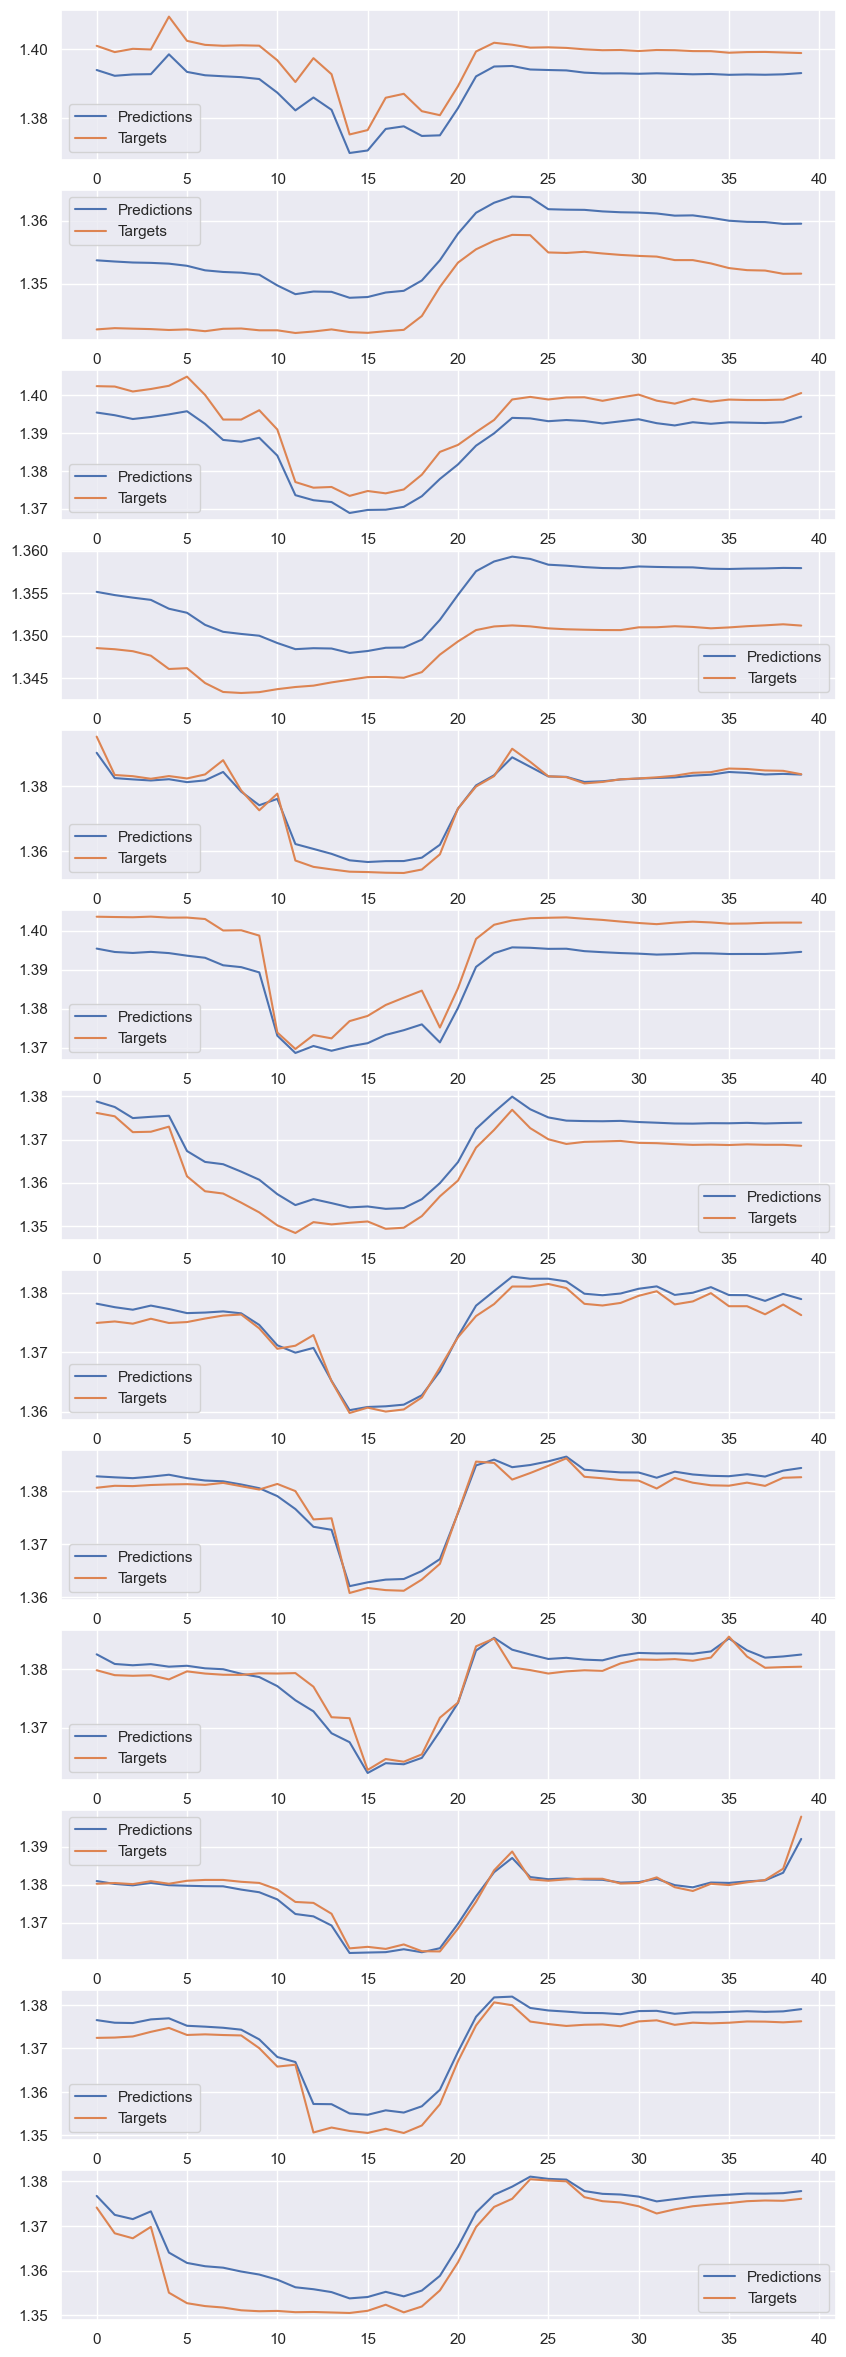

In [98]:
fig, ax = plt.subplots(len(training_features), figsize = (10,30))
preds_training = model.predict(training_features)
for subfig_idx in range(len(training_features)):
    ax[subfig_idx].plot(preds_training[subfig_idx], label = "Predictions")
    ax[subfig_idx].plot(training_targets[subfig_idx], label = "Targets")
    ax[subfig_idx].legend()

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
C:\Users\thomaswi\AppData\Local\Temp\ipykernel_23324\3204175905.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax[subfig_idx,0].set_ylabel("$ECD$ [$\mathrm{gcm}^{-3}$]",fontsize = 40)


Error between hfm and sensor 0.00022610713905841257
Error between preds and sensor 0.00019280881638909618
 
Error between hfm and sensor 5.4160960598647734e-05
Error between preds and sensor 0.00010715505907198317
 
(2, 40)


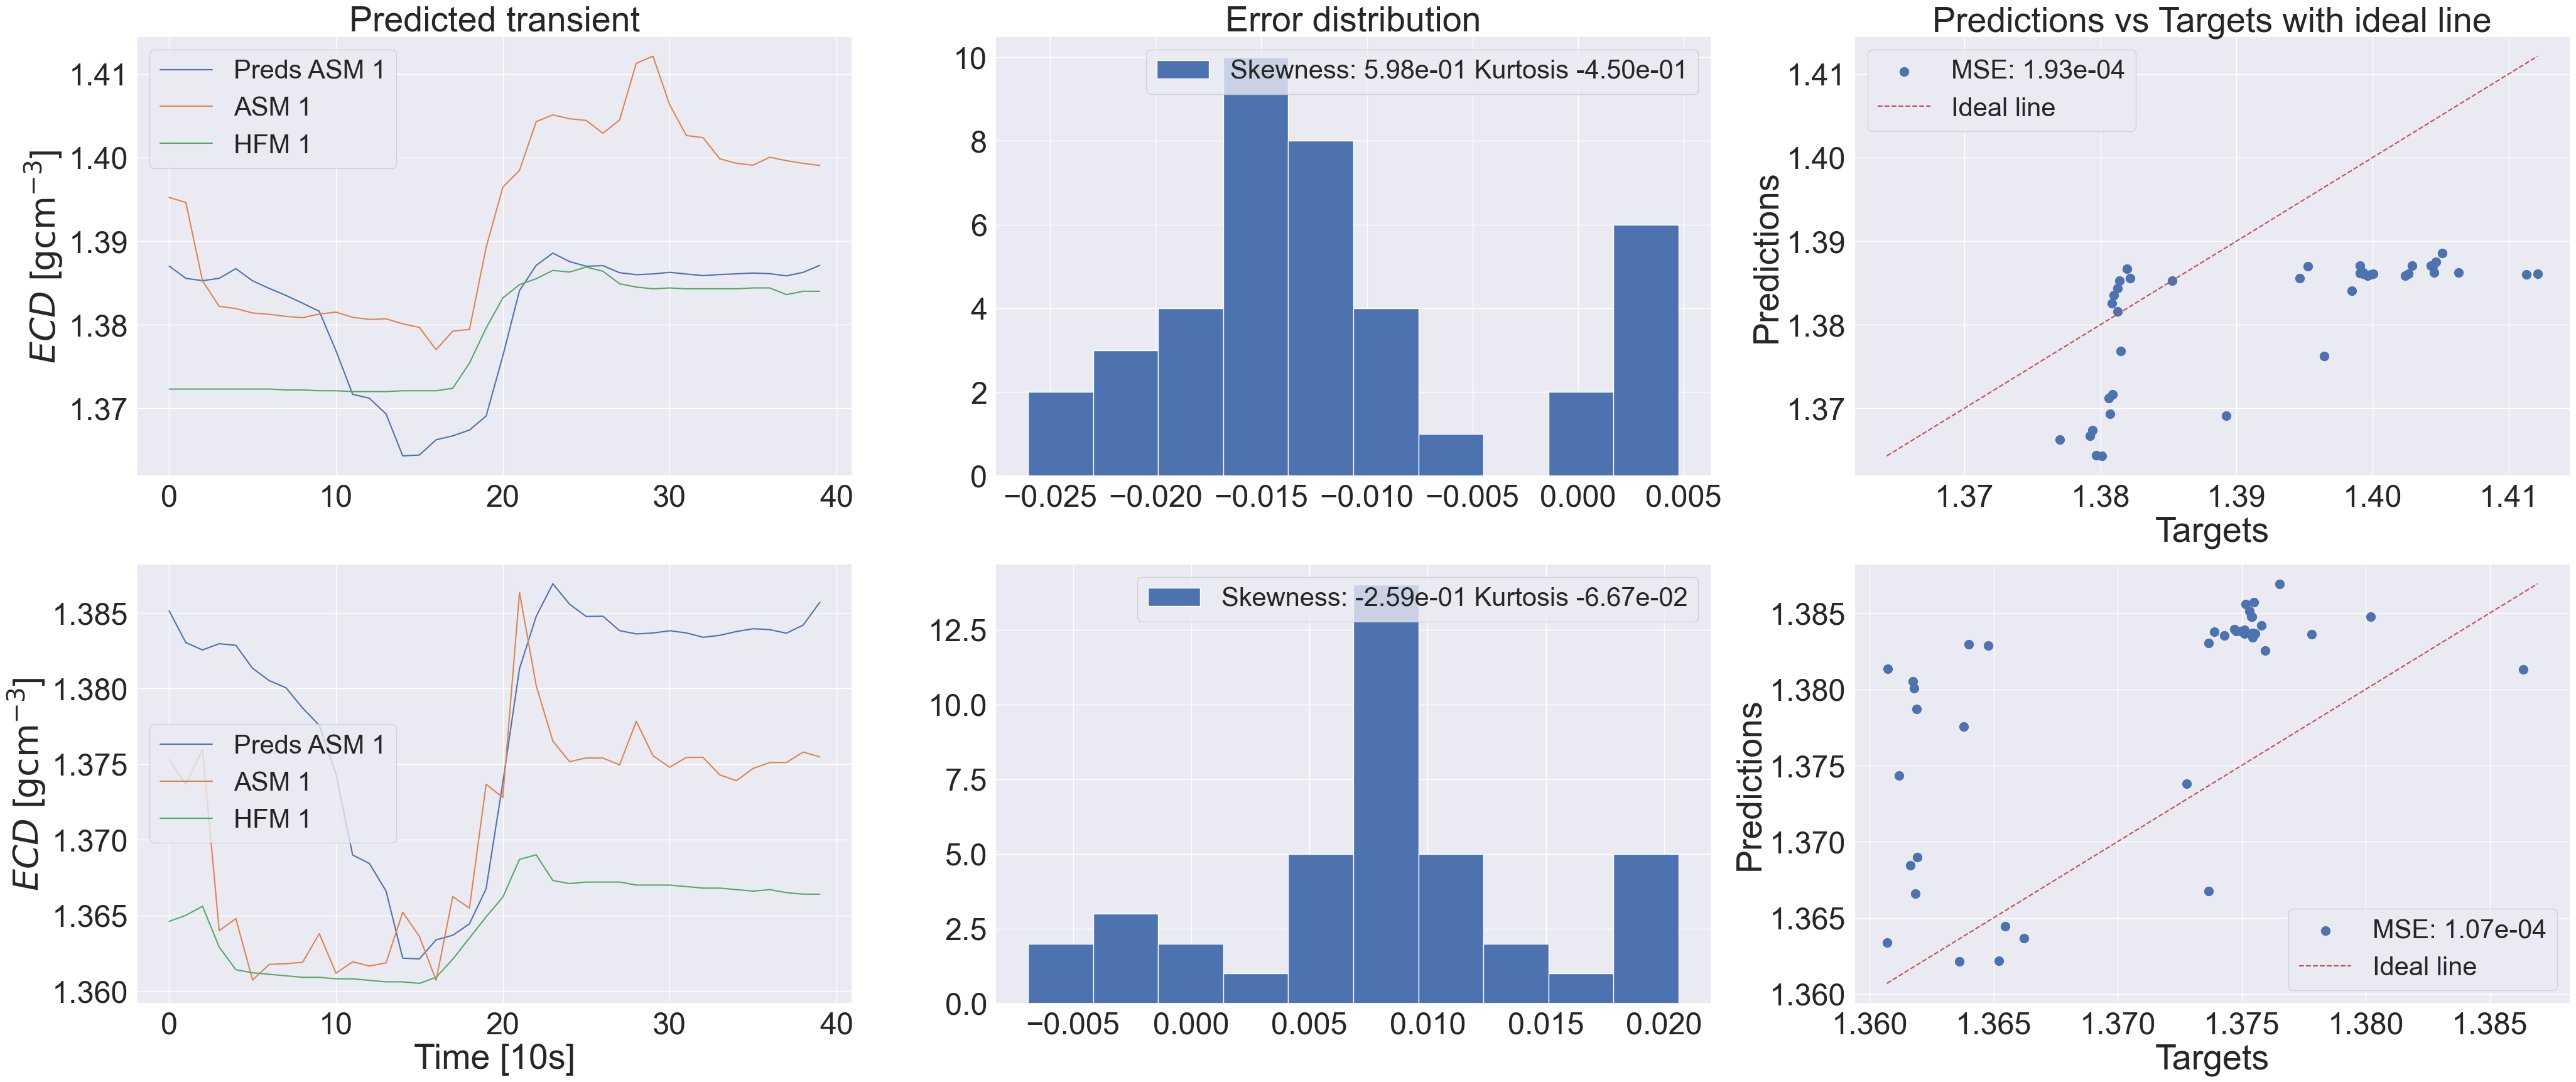

In [106]:
from scipy.stats import skew, kurtosis
fig, ax = plt.subplots(len(testing_features),3, figsize = (50,20))
preds = model.predict(testing_features)
plt.rcParams.update({
                     'xtick.labelsize': 35,  # X-axis tick labels
                     'ytick.labelsize': 35})  # Y-axis tick labels
ax[0,0].set_title("Predicted transient",fontsize = 40)
ax[0,1].set_title("Error distribution",fontsize = 40)
ax[0,2].set_title("Predictions vs Targets with ideal line",fontsize = 40)
ax[1,0].set_xlabel("Time [10s]",fontsize = 40)
for subfig_idx in range(len(testing_features)):
    ax[subfig_idx,0].plot(preds[subfig_idx], label = f"Preds ASM 1")
    ax[subfig_idx,0].plot(testing_targets[subfig_idx], label = "ASM 1")
    # ax[subfig_idx,0].plot(other_variables_validation[subfig_idx,:,0], label = "ASM 2")
    ax[subfig_idx,0].plot(other_variables_validation[subfig_idx,:,1], label = "HFM 1")
    # ax[subfig_idx,0].plot(other_variables_validation[subfig_idx,:,2], label = "HFM 2")
    ax[subfig_idx,0].set_ylabel("$ECD$ [$\mathrm{gcm}^{-3}$]",fontsize = 40)
    ax[subfig_idx,0].legend(fontsize = 30)

    error = preds[subfig_idx] - testing_targets[subfig_idx]
    ax[subfig_idx,1].hist(error, bins = 10, label = f'Skewness: {skew(error):.2e} Kurtosis {kurtosis(error):.2e}')
    ax[subfig_idx,1].legend(fontsize = 30)

    ax[subfig_idx,2].scatter(testing_targets[subfig_idx], preds[subfig_idx], color = 'C0', label = f"MSE: {np.mean(np.power(preds[subfig_idx] - testing_targets[subfig_idx],2)):.2e}", s = 100)
    min_val = min(min(testing_targets[subfig_idx]), min(preds[subfig_idx]))
    max_val = max(max(testing_targets[subfig_idx]), max(preds[subfig_idx]))
    ax[subfig_idx,2].plot([min_val, max_val], [min_val,max_val], color = 'C3', label = "Ideal line", linestyle = "--")
    ax[subfig_idx,2].set_xlabel("Targets",fontsize = 40)
    ax[subfig_idx,2].set_ylabel("Predictions",fontsize = 40)
    ax[subfig_idx,2].legend(fontsize = 30)

for id in range(len(testing_targets)):
    print("Error between hfm and sensor",np.mean(np.power(testing_targets[id]-other_variables_validation[id,:,1],2)))
    print("Error between preds and sensor",np.mean(np.power(testing_targets[id]-preds[id],2)))
    print(" ")
print(preds.shape)

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\thomaswi\AppData\Local\Temp\ipykernel_23324\2359847526.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$ECD$ $\mathrm{gcm}^{-3}$")


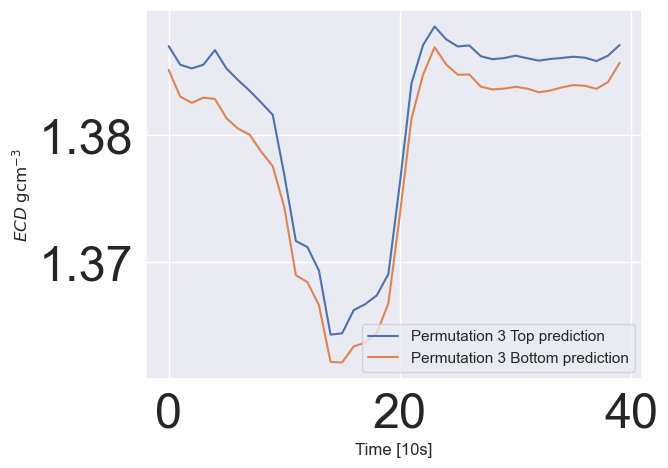

In [100]:
pred_to_pos = {0 : "Permutation 3 Top prediction", 1: 'Permutation 3 Bottom prediction'}
for idx,pred in enumerate(preds):
    plt.plot(pred, label = f'{pred_to_pos[idx]}')
    plt.ylabel("$ECD$ $\mathrm{gcm}^{-3}$")
    plt.xlabel("Time [10s]")
    plt.legend()
plt.show()

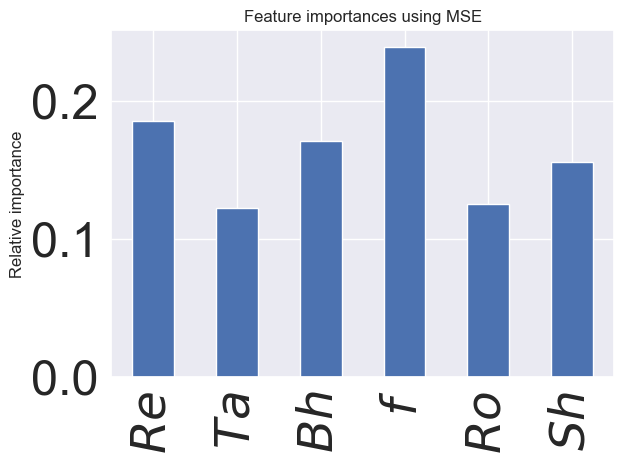

In [101]:
importances = model.feature_importances_
importances = importances.reshape(features.shape[1],features.shape[2])
importances = np.sum(importances, axis = 0)
forest_importances = pd.Series(importances, index = indices)
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MSE")
ax.set_ylabel("Relative importance")
fig.tight_layout()

In [102]:
mse_validation = []
for i in range(len(preds)):
    mse_validation.append(np.mean(np.power(preds[i] - testing_targets[i],2)))


In [103]:
# SAVING SOME PERMUTATIONS THAT GAVE GOOD RESULTS HERE
# interesting peaks on the testing set

permutation_1 = [ 8,  4,  6,  9, 11, 14, 13, 12, 10,  2,  1,  5,  3,  0,  7]


In [104]:
for index, element in enumerate(mse_validation):
    print(f'Testing MSE for test {index + 1} is: {element}')

Testing MSE for test 1 is: 0.00019280881638909618
Testing MSE for test 2 is: 0.00010715505907198317


In [105]:
print("Training mse is: ", np.mean(np.power(preds_training - training_targets, 2)))

Training mse is:  2.476827642168968e-05
